#  Create a model for the EWK density as a function of 2 Wilson coefficients



---

## 1. Import libraries


In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import histo_to_line, plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename, joint_shuffle

from backends import plot as plot, density_model as density_model, VBFZ_analysis as VBFZ


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


---

## 2. Configure model

- Register input $c_{\rm HWB}$ and ${\tilde c}_{\rm W}$ values, and a function which locates their filenames


In [2]:
#  Inputs config

cHWB_vals  = [-4.0, -2.0, 0.0, 2.0, 4.0]
cWtil_vals = [-0.4, -0.2, 0.0, 0.2, 0.4]

def get_input_fname (cHWB, cWtil) :
    cHWB_str  = f"{cHWB :.1f}".replace("-","m").replace(".","p")
    cWtil_str = f"{cWtil:.1f}".replace("-","m").replace(".","p")
    if (cHWB == 0) and (cWtil == 0) :
        return "../Data/SM_EWK_1M_rivet_output.pickle"
    if (cHWB == 0) :
        return f"../Data/cWtil_{cWtil_str}_full_400k_rivet_output.pickle"
    return f"../Data/cHWB_{cHWB_str}_cWtil_{cWtil_str}_full_200k_rivet_output.dat"

#return "../Data/SM_EWK_rivet_output.pickle"
#return "../Data/SM_EWK_500k_rivet_output.pickle"
#return "../Data/SM_EWK_1M_rivet_output.pickle"

- Global config options

In [3]:
#  Model config

num_gaussians              = 30
max_epochs                 = 200
batch_size                 = 5000
early_stopping_patience    = 15
early_stopping_min_delta   = 1e-10
validation_split           = -1

gauss_width_factor = 1./4.
batch_norm         = False
dropout            = -1.

white_linear_fraction_gauss = 0.
whitening_num_points        = 200
whitening_func_form         = "step"
whitening_alpha, whitening_beta, whitening_gamma = 4, 3, 1

load_whitening_funcs = ".whitening_funcs_paper_2D_nominal.pickle" 
save_whitening_funcs = None # ".whitening_funcs_paper_2D_nominal.pickle"

load_model_dir = ".EWK_density_model_paper_2D"
save_model_dir = ".EWK_density_model_paper_2D" # ".EWK_density_model_paper_2D"

learning_rate              = 1e-3       
learning_rate_evo_factor   = 0.5    
learning_rate_evo_patience = 3
optimiser                  = "adam"       # SGD, Adam or AdaDelta

obs_white_linear_fraction_data_space = {}
obs_white_linear_fraction_data_space ["Dphi_j_j"] = 0.8
obs_white_linear_fraction_data_space ["Dy_j_j"  ] = 0.8
obs_white_linear_fraction_data_space ["m_jj"    ] = 0.2
obs_white_linear_fraction_data_space ["m_ll"    ] = 0.8
obs_white_linear_fraction_data_space ["pT_j1"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_j2"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_jj"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_ll"   ] = 0.2
obs_white_linear_fraction_data_space ["rap_jj"  ] = 0.2
obs_white_linear_fraction_data_space ["rap_ll"  ] = 0.8


- Define domain for each observable
- Define which observables to discard
- Define how to order those that remain

In [4]:
#  Configure VBFZ observables
#
remove_observables = ["pT_jj", "N_jets", "N_gap_jets", "m_ll", "Dy_j_j", "rap_jj", "rap_ll", "pT_j2"]
VBFZ.configure(remove_observables, reverse=True)
print(f"Configured with {VBFZ.num_observables} observables: " + ", ".join(VBFZ.observables))
white_linear_fraction_data = [obs_white_linear_fraction_data_space[obs] if obs in obs_white_linear_fraction_data_space else 0. for obs in VBFZ.observables]

#  Configure plot functions with observable information
#
plot.int_observables   = VBFZ.int_observables
plot.observable_limits = VBFZ.transformed_observable_limits


Configured with 4 observables: pT_ll, pT_j1, m_jj, Dphi_j_j


---

## 3. Load input data

In [5]:
#  Load and format the data
#

data_tables = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        input_fname = get_input_fname (cHWB, cWtil)
        data_tables [(cHWB, cWtil)] = VBFZ.load_table(input_fname)
    

Loading events from file ../Data/cHWB_m4p0_cWtil_m0p4_full_200k_rivet_output.dat
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 130332 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 130259 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 130259 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 128561 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 126644 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 126644 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 126644 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 126644 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 126614 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 126352 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 126352 events survived
 --

 -- removing observable rap_ll
 -- removing observable pT_j2
 -- removing observable theta_ll
 -- removing observable theta_jj
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | pT_ll    | <class 'float'> |
    | 1      | pT_j1    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 0.7253         |
    +-------------------------+

* Number of events       : 126074
* Cross section per event: 0.252818
* Total cross section    : 0.1833619635121952 +/- 0.0005170171986547586 pb
Loading events from file ../Data/cHWB_m4p0_cWtil_0p4_full_200k_rivet_output.dat
 -- Table created with 200000 events
 --

 -- 131738 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130007 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128133 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128133 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128133 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128133 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128110 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 127876 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 127876 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 127876 events survived
 -- filtering observable N_jets between 2 and 5
 -- 127876 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 127876 events survived
 -- removing observable pT_jj
 -- removing observable N_jets
 -- removing o

 -- 264467 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 264437 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 264437 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 261020 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 257387 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 257387 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 257387 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 257387 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 257342 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 256868 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 256868 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 256868 events survived
 -- filtering observable N_jets between 2 and 5
 -- 256868 e

 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 132875 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 132825 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 132825 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131078 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129267 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129267 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129267 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129267 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129242 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 129021 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129021 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 

 -- removing observable N_gap_jets
 -- removing observable m_ll
 -- removing observable Dy_j_j
 -- removing observable rap_jj
 -- removing observable rap_ll
 -- removing observable pT_j2
 -- removing observable theta_ll
 -- removing observable theta_jj
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | pT_ll    | <class 'float'> |
    | 1      | pT_j1    | <class 'float'> |
    | 2      | m_jj     | <class 'float'> |
    | 3      | Dphi_j_j | <class 'float'> |
    +-------------------------------------+

* Registered the following weights:
    +-------------------------+
    | Name   | Sum of weights |
    +-------------------------+
    | weight | 1.4484         |
    +-------------------------+

* Number of events       : 129128
* Cross section per event: 0.253305
* Total cross section    : 0.3668759553227475 +/- 0.00102209292872619

 -- 132746 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 131057 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 129315 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 129315 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 129315 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 129315 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 129290 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 129048 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 129048 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 129048 events survived
 -- filtering observable N_jets between 2 and 5
 -- 129048 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 129048 events survived
 -- removing observable pT_jj
 -- removing observable N_jets
 -- removing o

---

## 4. Project the data onto the latent space

- If whitening functions already saved to file, load these, otherwise evaluate them at the SM
- Whiten the data, and add it to a dictionary
- Also produce a dictionary of normalised weights which will be used to train
- Alternatively, create a second dictionary which weights points at the boundaries of the parameter grid more strongly (since points in the bulk of the space are also constrained by their neighbours, but no such neighbours exist at the boundaries)

In [6]:

#  Load whitening funcs if requested
#
whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[VBFZ.transformed_observable_limits[key][0], VBFZ.transformed_observable_limits[key][1], whitening_num_points, white_linear_fraction_data[idx], 0.] for idx, key in enumerate(data_tables[(0,0)].keys)]

#  Evaluate whitening funcs if not loaded
#
if type(whitening_funcs) is type(None) :
    print("Evaluating whitening functions at the origin")
    data = data_tables [(0., 0.)]
    observables_origin, weights_origin = data.get_observables_and_weights()
    _, whitening_funcs = whiten_axes (observables_origin, data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=weights_origin, 
                                      func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)
     

Loading whitening functions from file .whitening_funcs_paper_2D_nominal.pickle


In [7]:

#  Whiten data
#   
observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        data = data_tables [(cHWB, cWtil)]
        observables, weights = data.get_observables_and_weights()
        #observables, weights = observables[:np.min([int(2e5), len(observables)])], weights[:np.min([int(2e5), len(observables)])]
        print(f"Whitening dataset for cHWB={cHWB}, cWtil={cWtil}")
        white_data_to_fit[(cHWB, cWtil)], whitening_funcs = whiten_axes (observables, data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=weights, 
                                                                         func_form=whitening_func_form, alpha=whitening_alpha, beta=whitening_beta, gamma=whitening_gamma)
        observable_data [(cHWB, cWtil)], weight_data [(cHWB, cWtil)] = observables, weights

#  Save whitening funcs
#   
if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

#  Normalise fit weights to unity
#   
weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Whitening dataset for cHWB=-4.0, cWtil=-0.4
Whitening dataset for cHWB=-4.0, cWtil=-0.2
Whitening dataset for cHWB=-4.0, cWtil=0.0
Whitening dataset for cHWB=-4.0, cWtil=0.2
Whitening dataset for cHWB=-4.0, cWtil=0.4
Whitening dataset for cHWB=-2.0, cWtil=-0.4
Whitening dataset for cHWB=-2.0, cWtil=-0.2
Whitening dataset for cHWB=-2.0, cWtil=0.0
Whitening dataset for cHWB=-2.0, cWtil=0.2
Whitening dataset for cHWB=-2.0, cWtil=0.4
Whitening dataset for cHWB=0.0, cWtil=-0.4
Whitening dataset for cHWB=0.0, cWtil=-0.2
Whitening dataset for cHWB=0.0, cWtil=0.0
Whitening dataset for cHWB=0.0, cWtil=0.2
Whitening dataset for cHWB=0.0, cWtil=0.4
Whitening dataset for cHWB=2.0, cWtil=-0.4
Whitening dataset for cHWB=2.0, cWtil=-0.2
Whitening dataset for cHWB=2.0, cWtil=0.0
Whitening dataset for cHWB=2.0, cWtil=0.2
Whitening dataset for cHWB=2.0, cWtil=0.4
Whitening dataset for cHWB=4.0, cWtil=-0.4
Whitening dataset for cHWB=4.0, cWtil=-0.2
Whitening dataset for cHWB=4.0, cWtil=0.0
Whitening data

In [8]:
#  Weight edges more highly to reduce interpolation bias

cHWB_sf, cWtil_sf = np.max(np.fabs(cHWB_vals)), np.max(np.fabs(cWtil_vals))
cHWB_sf, cWtil_sf = 1./cHWB_sf if (cHWB_sf>0) else 1., 1./cWtil_sf if (cWtil_sf>0) else 1.

weights_to_fit_2 = {k:(1+np.fabs(k[0])*cHWB_sf)*(1+np.fabs(k[1])*cWtil_sf)*i/np.sum(i) for k,i in weight_data.items()}

for key, weights in weights_to_fit_2.items() :
    print(f"Entry {key} weights normalised to {np.sum(weights):.3f}")


Entry (-4.0, -0.4) weights normalised to 4.000
Entry (-4.0, -0.2) weights normalised to 3.000
Entry (-4.0, 0.0) weights normalised to 2.000
Entry (-4.0, 0.2) weights normalised to 3.000
Entry (-4.0, 0.4) weights normalised to 4.000
Entry (-2.0, -0.4) weights normalised to 3.000
Entry (-2.0, -0.2) weights normalised to 2.250
Entry (-2.0, 0.0) weights normalised to 1.500
Entry (-2.0, 0.2) weights normalised to 2.250
Entry (-2.0, 0.4) weights normalised to 3.000
Entry (0.0, -0.4) weights normalised to 2.000
Entry (0.0, -0.2) weights normalised to 1.500
Entry (0.0, 0.0) weights normalised to 1.000
Entry (0.0, 0.2) weights normalised to 1.500
Entry (0.0, 0.4) weights normalised to 2.000
Entry (2.0, -0.4) weights normalised to 3.000
Entry (2.0, -0.2) weights normalised to 2.250
Entry (2.0, 0.0) weights normalised to 1.500
Entry (2.0, 0.2) weights normalised to 2.250
Entry (2.0, 0.4) weights normalised to 3.000
Entry (4.0, -0.4) weights normalised to 4.000
Entry (4.0, -0.2) weights normalised

---

# 5. Visualise the data at the SM, both on the data and latent spaces

Filter efficiency is 100.000%


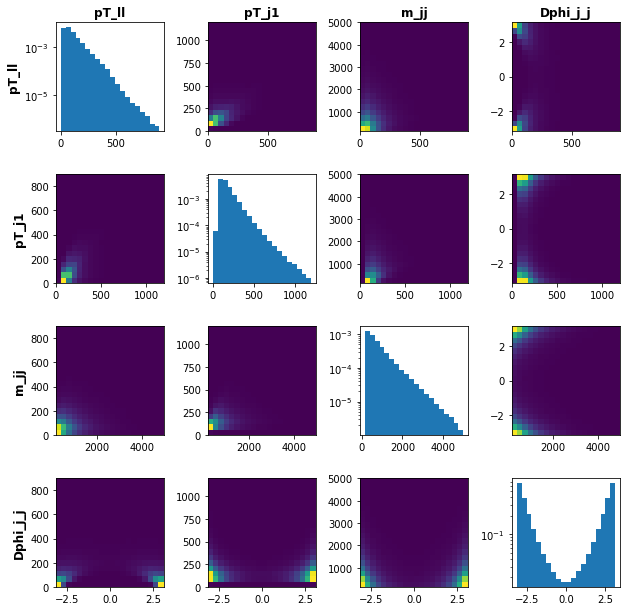

Filter efficiency is 100.000%


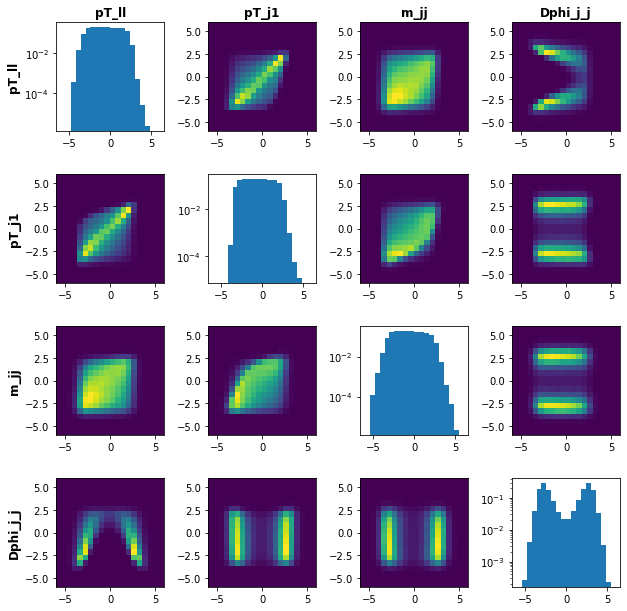

In [9]:

plot_data(observable_data  [(0,0)], weight_data   [(0,0)], keys=data.keys, bins=20, lims=True)
plot_data(white_data_to_fit[(0,0)], weights_to_fit[(0,0)], keys=data.keys, bins=20, lims=False)


In [10]:
#==================================
#===   LOAD / BUILD&FIT MODEL   ===
#==================================


#  Load model if requested, otherwise build
#
if type(load_model_dir) != type(None) :
    global_density_model = DensityModel.from_dir(load_model_dir)
else :
    obs_lims = []
    for obs_idx in range(VBFZ.num_observables) :     
        min_dp, max_dp     = np.min([np.min(data[:,obs_idx]) for c,data in white_data_to_fit.items()]), np.max([np.max(data[:,obs_idx]) for c,data in white_data_to_fit.items()])
        range_dp_per_gauss = (max_dp - min_dp) / num_gaussians
        obs_lims.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss]) 

    global_density_model = DensityModel(name        = "VBFZ_2D_density_model", 
                                 num_gaussians      = num_gaussians          , 
                                 num_conditions     = 2                      , 
                                 num_observables    = VBFZ.num_observables   ,
                                 observables_limits = obs_lims               ,
                                 verbose            = True                   , 
                                 gauss_width_factor = gauss_width_factor     ,
                                 gauss_mean_scale   = 1./8.                  ,
                                 gauss_frac_scale   = 1./8.                  ,
                                 gauss_sigma_scale  = 1./8.                  ,
                                 optimiser          = optimiser              ,
                                 learning_rate      = learning_rate          ,
                                 A1                 = 50                     ,
                                 A2                 = 0                      ,
                                 B1                 = 50                     ,
                                 B2                 = 20                     ,
                                 C_float            = 2                      ,
                                 D2                 = 3                      ,
                                 batch_norm         = batch_norm             ,
                                 dropout            = dropout                )
    #
    #   Make sure initial state has no NaN/Inf loss
    #
    global_density_model.ensure_valid_over_dataset (white_data_to_fit, weights_to_fit)


In [11]:
'''#  Fit model if not loaded
#
if type(load_model_dir) == type(None) :
    
    global_density_model.fit({(0,0):white_data_to_fit[(0,0)]}                        ,
                             {(0,0):weights_to_fit_2 [(0,0)]}                        ,
                             max_epochs_per_observable  = 50                         ,
                             early_stopping_patience    = early_stopping_patience    ,
                             early_stopping_min_delta   = early_stopping_min_delta   ,
                             validation_split           = validation_split           ,
                             batch_size_per_observable  = batch_size                 ,
                             learning_rate_evo_factor   = learning_rate_evo_factor   ,
                             learning_rate_evo_patience = learning_rate_evo_patience )'''

'#  Fit model if not loaded\n#\nif type(load_model_dir) == type(None) :\n    \n    global_density_model.fit({(0,0):white_data_to_fit[(0,0)]}                        ,\n                             {(0,0):weights_to_fit_2 [(0,0)]}                        ,\n                             max_epochs_per_observable  = 50                         ,\n                             early_stopping_patience    = early_stopping_patience    ,\n                             early_stopping_min_delta   = early_stopping_min_delta   ,\n                             validation_split           = validation_split           ,\n                             batch_size_per_observable  = batch_size                 ,\n                             learning_rate_evo_factor   = learning_rate_evo_factor   ,\n                             learning_rate_evo_patience = learning_rate_evo_patience )'

In [12]:
#  Fit model if not loaded
#
if type(load_model_dir) == type(None) :
    
    global_density_model.fit(white_data_to_fit                                       ,
                             weights_to_fit_2                                        ,
                             max_epochs_per_observable  = max_epochs                 ,
                             early_stopping_patience    = early_stopping_patience    ,
                             early_stopping_min_delta   = early_stopping_min_delta   ,
                             validation_split           = validation_split           ,
                             batch_size_per_observable  = batch_size                 ,
                             learning_rate_evo_factor   = learning_rate_evo_factor   ,
                             learning_rate_evo_patience = learning_rate_evo_patience )

In [13]:
#  Improve model
#
'''if True :
    
    global_density_model.fit(white_data_to_fit                                       ,
                             weights_to_fit_2                                        ,
                             max_epochs_per_observable  = 100                        ,
                             early_stopping_patience    = early_stopping_patience    ,
                             early_stopping_min_delta   = early_stopping_min_delta   ,
                             validation_split           = validation_split           ,
                             batch_size_per_observable  = batch_size                 ,
                             learning_rate_evo_factor   = learning_rate_evo_factor   ,
                             learning_rate_evo_patience = learning_rate_evo_patience )'''

'if True :\n    \n    global_density_model.fit(white_data_to_fit                                       ,\n                             weights_to_fit_2                                        ,\n                             max_epochs_per_observable  = 100                        ,\n                             early_stopping_patience    = early_stopping_patience    ,\n                             early_stopping_min_delta   = early_stopping_min_delta   ,\n                             validation_split           = validation_split           ,\n                             batch_size_per_observable  = batch_size                 ,\n                             learning_rate_evo_factor   = learning_rate_evo_factor   ,\n                             learning_rate_evo_patience = learning_rate_evo_patience )'

In [14]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    global_density_model.save_to_dir(save_model_dir)
    

In [94]:
#  Generate a large number of datapoints at 0.
#

n_gen = 100000

print(f"Generating {n_gen} fake datapoints for [cHWB, cWtil] = [0, 0]")
start = time.time()
fake_white_datapoints_SM = global_density_model.sample(n_gen, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at (0, 0) in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for  (0, 0)")
start = time.time()
fake_datapoints_SM = unwhiten_axes(fake_white_datapoints_SM, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at (0, 0) in {int(end-start):.0f}s")


Generating 100000 fake datapoints for [cHWB, cWtil] = [0, 0]
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 3
100000 datapoints generated at (0, 0) in 76s
Unwhitening fake datapoints for  (0, 0)
100000 datapoints unwhitened at (0, 0) in 2s


In [112]:
n_gen = len(observable_data[(0,0)])

print(f"Generating {n_gen} fake datapoints for [cHWB, cWtil] = [0, 0]")
start = time.time()
fake_white_datapoints_SM_big = global_density_model.sample(n_gen, [0, 0])
end = time.time()
print(f"{n_gen} datapoints generated at cWtil=0 in {int(end-start):.0f}s")

#  Unwhiten generated data
#

print("Unwhitening fake datapoints for  (0, 0)")
start = time.time()
fake_datapoints_SM_big = unwhiten_axes(fake_white_datapoints_SM_big, whitening_funcs)
end = time.time()
print(f"{n_gen} datapoints unwhitened at (0, 0) in {int(end-start):.0f}s")

Generating 641867 fake datapoints for [cHWB, cWtil] = [0, 0]
INFO       DensityModel.sample         Sampling 641867 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 641867 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 641867 datapoints, observable index is 2
INFO       DensityModel.sample         Sampling 641867 datapoints, observable index is 3
641867 datapoints generated at cWtil=0 in 540s
Unwhitening fake datapoints for  (0, 0)
641867 datapoints unwhitened at (0, 0) in 19s


In [95]:
#  Get datapoint likelihoods at 0 hypothesis
#

fake_datapoint_SM_likelihood = global_density_model.evaluate([0, 0], fake_white_datapoints_SM)

fake_datapoint_weights = {}
for cHWB in cHWB_vals :
    for cWtil in cWtil_vals :
        start = time.time()
        fake_datapoint_weights [(cHWB, cWtil)] = global_density_model.evaluate([cHWB, cWtil], fake_white_datapoints_SM) / fake_datapoint_SM_likelihood
        end = time.time()
        print(f"{len(fake_white_datapoints_SM)} datapoints evaluated at {cHWB, cWtil} in {(end-start):.2f}s")


100000 datapoints evaluated at (-4.0, -0.4) in 5.28s
100000 datapoints evaluated at (-4.0, -0.2) in 5.26s
100000 datapoints evaluated at (-4.0, 0.0) in 5.75s
100000 datapoints evaluated at (-4.0, 0.2) in 5.01s
100000 datapoints evaluated at (-4.0, 0.4) in 5.03s
100000 datapoints evaluated at (-2.0, -0.4) in 5.02s
100000 datapoints evaluated at (-2.0, -0.2) in 5.01s
100000 datapoints evaluated at (-2.0, 0.0) in 5.02s
100000 datapoints evaluated at (-2.0, 0.2) in 5.02s
100000 datapoints evaluated at (-2.0, 0.4) in 5.08s
100000 datapoints evaluated at (0.0, -0.4) in 5.13s
100000 datapoints evaluated at (0.0, -0.2) in 5.08s
100000 datapoints evaluated at (0.0, 0.0) in 5.14s
100000 datapoints evaluated at (0.0, 0.2) in 5.14s
100000 datapoints evaluated at (0.0, 0.4) in 5.08s
100000 datapoints evaluated at (2.0, -0.4) in 5.14s
100000 datapoints evaluated at (2.0, -0.2) in 5.08s
100000 datapoints evaluated at (2.0, 0.0) in 5.13s
100000 datapoints evaluated at (2.0, 0.2) in 5.05s
100000 datapo

In [226]:
#  Get a plot label for each observable
#

obs_labels = {}
obs_labels ["m_jj"    ] = r"$m_{jj}$  [TeV]"
obs_labels ["pT_ll"   ] = r"$p_{T}^{ll}$  [GeV]"
obs_labels ["Dphi_j_j"] = r"$\Delta\phi\left(j,j\right)$"
obs_labels ["pT_j1"   ] = r"$p_{T}^{j1}$  [GeV]"


#  Plot the datapoints provided
#
def get_obs_label (obs) :
    if obs in obs_labels :
        return obs_labels[obs]
    return f"'{obs}'"

#  Plot the datapoints provided
#
def plot_observable_on_axis2 (ax, observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20, label=None, linecolor="k", fillcolor="grey", normed=True, ebar=False, offset=-1., log=False) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if type(bins) not in [list, np.ndarray] :
        if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
        else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True, normed=normed)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, np.log(data_z+offset) if log else data_z+offset, color=linecolor, label=label, linewidth=2)
    if ebar : 
        if log :
            ax.fill_between(data_x, np.log(data_z+data_ez+offset), np.log(data_z-data_ez+offset), alpha=0.4, color=fillcolor)
        else :
            ax.fill_between(data_x, data_z+data_ez+offset, data_z-data_ez+offset, alpha=0.4, color=fillcolor)
        
    return data_x, data_z+offset, data_ez
        

In [204]:
num_observables = VBFZ.num_observables
observables_order = VBFZ.observables
observable_limits = VBFZ.observable_limits
int_observables = VBFZ.int_observables

In [340]:
#  
#
def get_bins(data, weights=None, limits=None, obs=None, max_err=-1) :
    if type(limits ) == type(None) :
        if obs : limits = observable_limits[obs]
        else   : limits = [np.min(data), np.max(data)]
    if type(weights) == type(None) : weights   = np.ones(shape=(len(data),))
    if type(obs    ) == type(None) : increment = (limits[1] - limits[0]) / 100
    elif obs == "Dphi_j_j" : increment = np.pi / 16
    elif obs == "pT_j1" : 
        increment = 10
        if max_err < 0 : max_err   = 0.015
    elif "pT" in obs : increment = 10
    elif "m_" in obs       : 
        increment = 25
        if max_err < 0 : max_err   = 0.02
    else : increment = (limits[1] - limits[0]) / 100
    if max_err < 0 : max_err = 0.05
    lim_range = limits[1] - limits[0]
    bins      = [x for x in np.linspace(limits[0], limits[1], 1+int(lim_range/increment))]
    keep_merging = True
    while keep_merging :
        vals, _   = np.histogram(data, bins=bins)
        errs      = np.sqrt(vals)
        frac_errs = [x for x in plot.safe_divide(errs, vals)]
        curr_err  = np.max(frac_errs)
        if len(bins) == 2 :
            keep_merging = False
        elif 0 in frac_errs :
            idx = len(frac_errs) - frac_errs[::-1].index(0) - 1
            del bins[idx]
        elif curr_err < max_err :
            keep_merging = False
        else :
            idx = frac_errs.index(curr_err)
            if   idx == 0             : del bins[1]
            elif idx == len(bins) - 2 : del bins[-2]
            elif frac_errs[idx-1] > frac_errs[idx>1] : del bins[idx]
            else : del bins[idx+1]
    return bins


In [341]:
#
#
def get_ticks (padmin, padmax, pad=0.2) :
    ymin, ymax = np.exp(padmin), np.exp(padmax)
    abs_padmax = np.max(np.fabs([padmin, padmax]))
    abs_ymax   = np.exp(abs_padmax)
    if abs_ymax >= 2 :
        mag, y = -1, abs_ymax - 1
        while y > 1 :
            y /= 10
            mag += 1
    else :
        mag, y = 0, abs_ymax - 1
        while y < 1 :
            y *= 10
            mag -= 1
    fac = np.power(10., mag)
    val = math.floor((1-pad) * (abs_ymax-1) / fac)
    major_ticks = np.log([1 / (1 + val*fac), 1, 1 + val*fac])
    major_ticks = np.array([t for t in major_ticks if t>=padmin and t<=padmax])
    i, v, minor_ticks = 0., 0., []
    while v < padmax :
        minor_ticks.append(v)
        i += 0.2
        v  = np.log(1. + i*val*fac)
    i, v = 0.2, np.log(1. / (1 + 0.2*val*fac))
    while v > padmin :
        minor_ticks.append(v)
        i += 0.2
        v  = np.log(1. / (1. + i*val*fac))
    minor_ticks = np.array(sorted(minor_ticks))
    return major_ticks, minor_ticks
    

In [383]:
import math

def get_val_and_fac (y, pad=0.) :
    if y >= 2 :
        mag, yp = -1, y - 1
        while yp > 1 :
            yp /= 10
            mag += 1
        fac = np.power(10., mag)
        val = math.floor((1-pad) * y / fac)
    else :
        mag, yp = 0, np.fabs(y - 1)
        while yp < 1 :
            yp *= 10
            mag -= 1
        fac = np.power(10., mag)
        val = math.ceil((1+pad) * y / fac) 
    fac = np.power(10., mag)
    return val, fac
        

#
#
def get_ticks (ymin, ymax, pad=0.) :
    val_lo, fac_lo = get_val_and_fac(ymin, pad=pad)
    val_hi, fac_hi = get_val_and_fac(ymax, pad=pad)
    return np.array([val_lo*fac_lo, 1, val_hi*fac_hi])



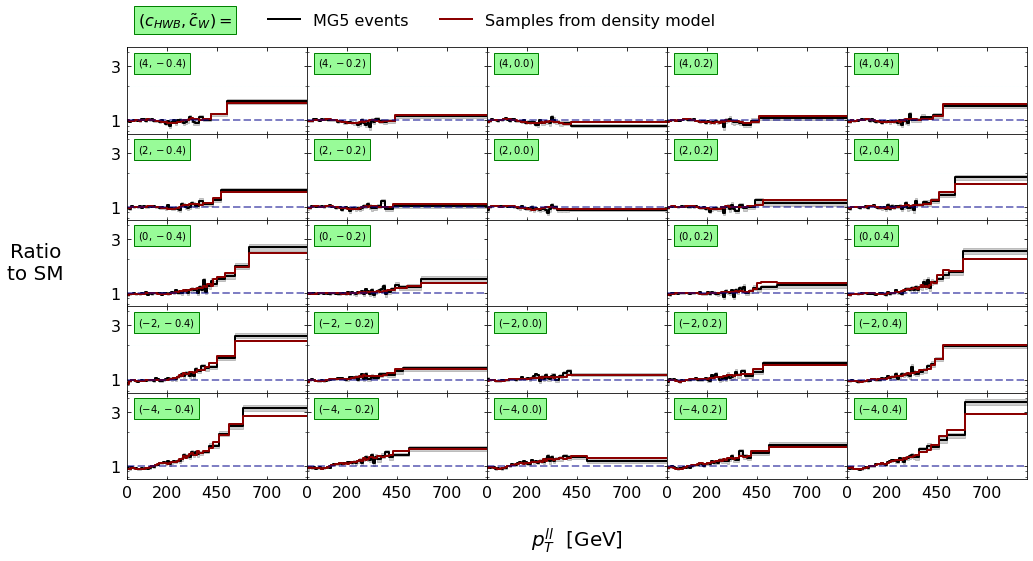

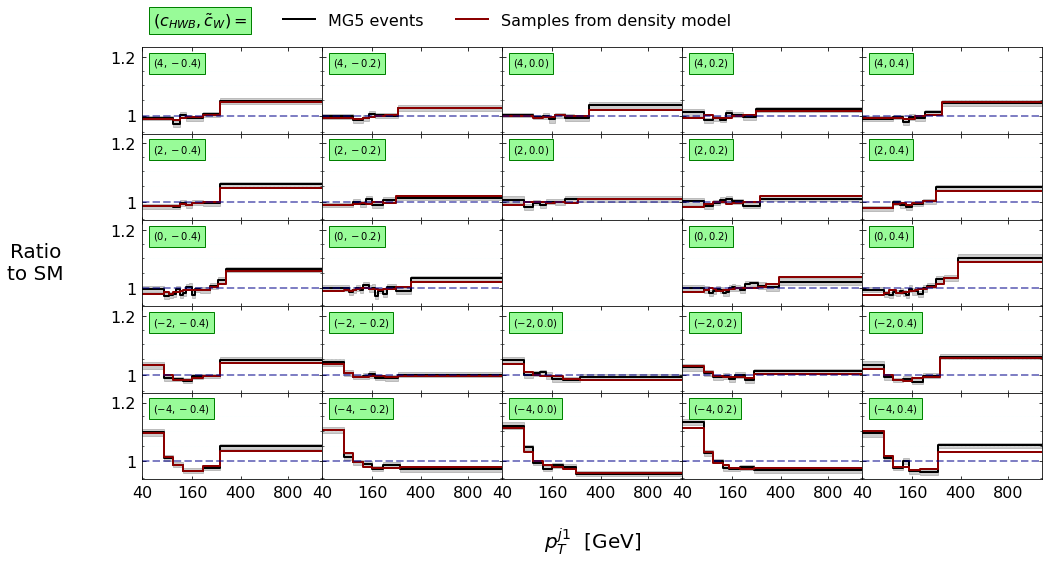

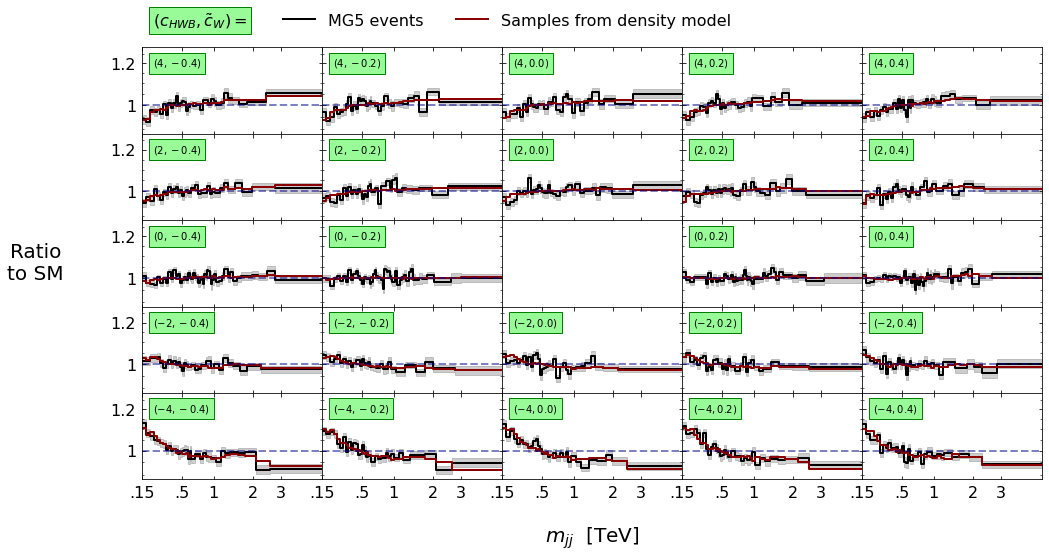

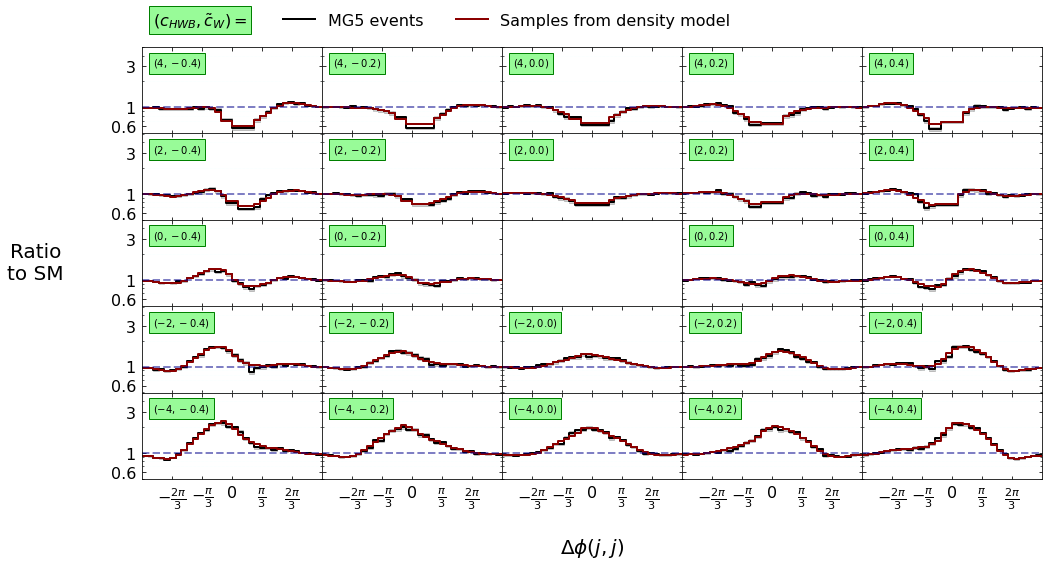

In [390]:
import math
    
log_axis_functions = (lambda x : x**(1./3.), lambda x : x*x*x)

ticks = {}
ticks["pT_ll"    ] = [0, 200, 450, 700]
ticks["pT_j1"    ] = [40, 160, 400, 800]
ticks["m_jj"     ] = [150, 500, 1000, 2000, 3000]
ticks["Dphi_j_j" ] = [-2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3]

ticklabels = {}
ticklabels["Dphi_j_j"] = [r"$-\frac{2\pi}{3}$", r"$-\frac{\pi}{3}$", "0", r"$\frac{\pi}{3}$", r"$\frac{2\pi}{3}$"]
ticklabels["m_jj"    ] = [".15", ".5", "1", "2", "3"]

cHWB_plot_vals  = cHWB_vals [::-1]
cWtil_plot_vals = cWtil_vals

num_rows, num_cols = len(cHWB_plot_vals), len(cWtil_vals)
height  , width    = 1.2*num_rows, 2.5*num_cols
for obs_idx, obs in enumerate(observables_order) :
    real_datapoints_SM, real_weights_SM = observable_data[(0, 0)], weights_to_fit[(0,0)]
    n_fake = len(fake_datapoints_SM)
    fig    = plt.figure(figsize=(width, height))
    first_axis, axes, ymin, ymax = None, [], 1, 1
    for row_idx, cHWB in enumerate(cHWB_plot_vals) :
        for col_idx, cWtil in enumerate(cWtil_plot_vals) :
            if (cHWB==0) and (cWtil==0) : continue
            ax   = fig.add_axes([col_idx/num_cols, (num_rows-1-row_idx)/num_rows, 1./num_cols, 1./num_rows])
            if type(first_axis) == type(None) : first_axis = ax
            axes.append(ax)
            data = data_tables [(cHWB, cWtil)]
            observables, weights = data.get_observables_and_weights()
            bins = get_bins(observables[:,obs_idx], weights=weights, obs=obs)
            data_x, y1, ey1 = plot_observable_on_axis2 (ax, obs, observables       , real_datapoints_SM, weights                              , real_weights_SM, keys=data.keys, bins=bins, normed=True, ebar=True, label="MG5 events", offset=0, log=False)
            data_x, y2, ey2 = plot_observable_on_axis2 (ax, obs, fake_datapoints_SM, fake_datapoints_SM, fake_datapoint_weights[(cHWB, cWtil)].reshape(n_fake), fake_datapoint_weights[(0,0)].reshape(n_fake), keys=data.keys, bins=bins, normed=True, label="Samples from density model", linecolor="darkred", fillcolor="red", offset=0, log=False)
            ax.set_xlim([bins[0], bins[-1]])
            ymin = np.min([ymin, np.min(y1-ey1), np.min(y2-ey2)])
            ymax = np.max([ymax, np.max(y1+ey1), np.max(y2+ey2)])
            ax.tick_params(which="both", right=True, top=True, labelsize=16, pad=6, direction="in")
            if (row_idx == 2) and (col_idx == 0) :
                ax.set_ylabel("Ratio\nto SM", fontsize=20, labelpad=75, rotation=0, va="center")
            if (row_idx == num_rows-1) and (col_idx == 2) :
                ax.set_xlabel(get_obs_label(obs), fontsize=20, labelpad=25)
            ax.set_yscale("log")
            if obs == "pT_ll"    :
                ax.yaxis.set_ticks([1, 3])
                ax.yaxis.set_ticklabels(["1", "3"])
            if obs == "pT_j1"    : 
                ax.yaxis.set_ticks([1, 1.2])
                ax.yaxis.set_ticklabels(["1", "1.2"])
            if obs == "m_jj"     : 
                ax.yaxis.set_ticks([1, 1.2])
                ax.yaxis.set_ticklabels(["1", "1.2"])
            if obs == "Dphi_j_j" : 
                ax.yaxis.set_ticks([0.6, 1, 3])
                ax.yaxis.set_ticklabels(["0.6", "1", "3"])
            if col_idx == 0  :
                ax.yaxis.set_ticklabels([], minor=True)
            else :
                ax.yaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([], minor=True)
            ax.text(0.06, 0.89, f"$({cHWB:.0f},{cWtil:.1f})$", ha="left", va="top", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0), transform=ax.transAxes)
            if obs not in ["Dphi_j_j", "pT_ll"] : ax.set_xscale("function", functions=log_axis_functions)
            if obs in ticks : ax.xaxis.set_ticks(ticks[obs])
            if row_idx != num_rows - 1 : ax.xaxis.set_ticklabels([])
            elif obs in ticklabels : ax.xaxis.set_ticklabels(ticklabels[obs])
            #ax.axhline(0, linestyle="-" , c="grey", linewidth=2)
            ax.axhline(1, linestyle="--" , c="darkblue", linewidth=2, alpha=0.5)
            ax.grid(True, which="minor", axis="y", c='azure', ls=':', lw=0.5)
    pad_factor = 0.08 if obs=="pT_ll" else 0.45
    padmin, padmax = (1+0.05)*np.log(ymin) - 0.05*np.log(ymax), (1+pad_factor)*np.log(ymax) - pad_factor*np.log(ymin)
    #padmin, padmax = (1+0.05)*ymin - 0.05*ymax, (1+pad_factor)*ymax - pad_factor*ymin
    for ax in axes :
        ax.set_ylim(np.exp([padmin, padmax]))
        #ax.set_ylim([padmin, padmax])
        #ax.yaxis.set_ticks(get_ticks(padmin, padmax, pad=0.2))
    first_axis.text(0.06, 1.2, r"$(c_{HWB}, {\tilde c}_W) = $", ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0), transform=first_axis.transAxes, fontsize=16)
    first_axis.legend(loc=(0.75, 1.15), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=16)
    plt.savefig(f"figures/paper2D_model/EWK_events_1D_{obs}.pdf", bbox_inches="tight")
    plt.show()


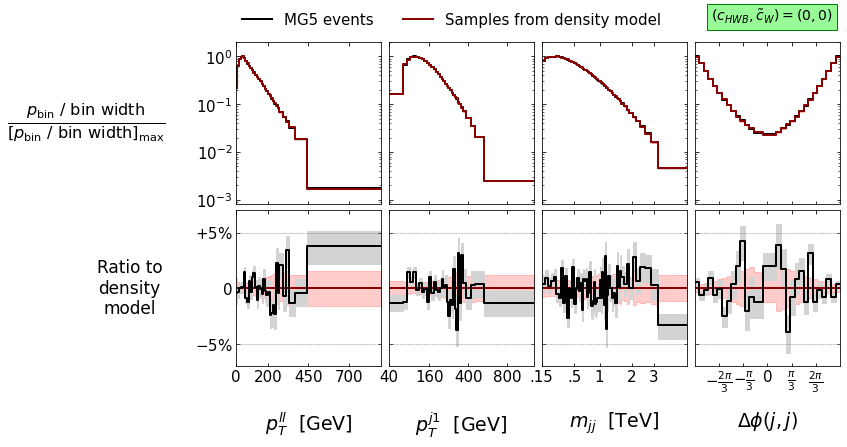

In [391]:

#  Data space distribution & ratio (c=0)
def histo_to_line (bins, values, errors) :
    X, Z, EZ = [], [], []
    for zp in values :
        Z .append(zp)
        Z .append(zp)
    for ezp in errors :
        EZ.append(ezp)
        EZ.append(ezp)
    for i in range(len(bins)-1) :
        X .append(bins[i])
        X .append(bins[i+1])
    return np.array(X), np.array(Z), np.array(EZ)


fig = plt.figure(figsize=(8.5, 4.5))

axes1, axes2 = [], []
ylos , yhis  = [], []

for obs_idx, observable in enumerate(observables_order) :
    
    #  Get axis x coordinates
    xlo    = obs_idx / num_observables
    xwidth = .95     / num_observables
    
    #  ============
    #     AXIS 1
    #  ============

    ax1 = fig.add_axes([xlo, 0.50, xwidth, 0.5])
    
    datapoints_true, weights_true = data_tables [(0,0)].get_observables_and_weights()
    
    obs_lims   = observable_limits[observable]
    num_bins   = 20
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins   = get_bins(datapoints_true[:,obs_idx], weights=weights_true, obs=observable, max_err=0.02 if "Dphi" in observable else 0.015)
    
    bins      = np.array(bins)
    binwidths = bins[1:] - bins[:-1]
        
    hvals1, _ = np.histogram(datapoints_true[:,obs_idx], bins=bins, weights=weights_true             )
    herrs1, _ = np.histogram(datapoints_true[:,obs_idx], bins=bins, weights=weights_true*weights_true)
    herrs1    = np.sqrt(herrs1)
    hvals1, herrs1 = hvals1/np.sum(weights_true)/binwidths, herrs1/np.sum(weights_true)/binwidths
    norm      = np.max(hvals1)
    hvals1, herrs1 = hvals1/norm, herrs1/norm
    hvals2, _ = np.histogram(fake_datapoints_SM_big[:,obs_idx], bins=bins)
    herrs2    = np.sqrt(hvals2)
    hvals2, herrs2 = hvals2/len(fake_datapoints_SM_big)/binwidths, herrs2/len(fake_datapoints_SM_big)/binwidths
    hvals2, herrs2 = hvals2/norm, herrs2/norm
   
    plot_x, plot_y1, plot_ey1 = histo_to_line(bins, hvals1, herrs1)
    _     , plot_y2, plot_ey2 = histo_to_line(bins, hvals2, herrs2)
    
    ax1.plot(plot_x, plot_y1, "-", color="k"      , linewidth=2, label="MG5 events")
    ax1.fill_between(plot_x, plot_y1-plot_ey1, plot_y1+plot_ey1, color="lightgrey", alpha=1)
    ax1.plot(plot_x, plot_y2, "-", color="darkred", linewidth=2, label="Samples from density model")
    ax1.fill_between(plot_x, plot_y2-plot_ey2, plot_y2+plot_ey2, color="red", alpha=0.2)
    ax1.set_yscale("log")
    
    # Save y values range
    ylo, yhi = np.min([plot_y1-plot_ey1, plot_y2-plot_ey2]), np.max([plot_y1+plot_ey1, plot_y2+plot_ey2])
    ylos.append(ylo)
    yhis.append(yhi)
        
    
    #  ============
    #     AXIS 2
    #  ============

    ax2 = fig.add_axes([xlo, 0, xwidth, 0.48])
    
    ax2.axhline(0, c="darkred", linewidth=2)
    ax2.fill_between(plot_x, -plot_ey2/plot_y2, plot_ey2/plot_y2, color="red", alpha=0.2)
    ax2.plot(plot_x, (plot_y1-plot_y2)/plot_y2, c="k", linewidth=2)
    ax2.fill_between(plot_x, (plot_y1-plot_ey1-plot_y2)/plot_y1, (plot_y1+plot_ey1-plot_y2)/plot_y1, color="lightgrey", alpha=1)
    ax2.set_ylim([-0.07, 0.07])
    
    for h in [-0.05, 0.05] :
        ax2.axhline(h, linestyle="--", c="grey", linewidth=0.5)
    
    #  Format x axis scale
    if observable not in ["Dphi_j_j", "pT_ll"] : 
        ax1.set_xscale("function", functions=log_axis_functions)
        ax2.set_xscale("function", functions=log_axis_functions)
    
    #  Set y axis tick labels    
    if obs_idx > 0 :
        ax1.get_yaxis().set_ticklabels([])
        ax2.get_yaxis().set_ticklabels([])
        
    #  Set x axis labels
    ax2.set_xlabel(get_obs_label(observable), fontsize=19, labelpad=15 if "Dphi" in observable else 26)
        
    #  Set y axis labels
    if obs_idx == 0 : 
        ax1.set_ylabel(r"$\frac{p_{\rm bin}~/~{\rm bin~width}}{[p_{\rm bin}~/~{\rm bin~width}]_{\rm max}}$", fontsize=23, labelpad=110, rotation=0, va="center")
        ax2.set_ylabel("Ratio to\ndensity\nmodel", fontsize=17, labelpad=65, rotation=0, va="center")
        ax1.legend(loc=(0, 1.05), frameon=True, edgecolor="white", facecolor="white", ncol=2, fontsize=15)
      
    #  Draw cWtil label
    if obs_idx == (num_observables-1) :
        ax1.text(0.95, 1.1, r"$(c_{HWB}, {\tilde c}_W) = (0,0)$",fontsize=14, transform=ax1.transAxes, ha="right", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0))
    
    #  Set x limits
    ax1.set_xlim([bins[0], bins[-1]])
    ax2.set_xlim([bins[0], bins[-1]])
    
    #  Set x ticks
    if obs in ticks :
        ax1.get_xaxis().set_ticks(ticks[observable])
        ax2.get_xaxis().set_ticks(ticks[observable])
    ax1.get_xaxis().set_ticklabels([])
    if observable in ticklabels :
        ax2.get_xaxis().set_ticklabels(ticklabels[observable])
    
    #  Set tick params
    ax1.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    ax2.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)
    
    #  Save axes
    axes1.append(ax1)
    axes2.append(ax2)

        
#  Set consistent axis y lims
for ax in axes1 :
    ax.set_ylim([np.min(ylos)/2., 2.*np.max(yhis)])

axes2[0].set_yticks     ([-0.05, 0, 0.05])
axes2[0].set_yticklabels([r"$-5\%$", r"$0$", r"$+5\%$"])
 
plt.savefig(f"figures/paper2D_model/EWK_events_SM_1D.pdf", bbox_inches="tight")
plt.show()


In [194]:

lin_ticks = {}
lin_ticks["pT_ll"    ] = [0, 300, 600]
lin_ticks["pT_j1"    ] = [40, 500, 1000]
lin_ticks["m_jj"     ] = [150, 2000, 4000]
lin_ticks["Dphi_j_j" ] = [-2*np.pi/3, 0, 2*np.pi/3]

lin_ticklabels = {}
lin_ticklabels["pT_ll"   ] = ["0", "300", "600"]
lin_ticklabels["pT_j1"   ] = ["40", "500", "1000"]
lin_ticklabels["m_jj"    ] = [".15", "2", "4"]
lin_ticklabels["Dphi_j_j"] = [r"$-\frac{2\pi}{3}$", "0", r"$\frac{2\pi}{3}$"]


def plot_data_adv (datapoints, weights=None, label="", savefig="") :
    
    #  If no weights provided then assume uniform
    if type(weights) == type(None) :
        weights = np.ones(shape=(datapoints.shape[0],))
    
    #  Get histo bins
    get_bins = {}
    for obs_idx_x, obs_x in enumerate(observables_order) :
        obs_lims_x = observable_limits[obs_x]
        num_bins_x = 20
        if obs_x in int_observables : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0]-0.5, obs_lims_x[1]+0.5, 1+(obs_lims_x[1]-obs_lims_x[0]))
        else                        : get_bins[obs_idx_x] = np.linspace(obs_lims_x[0], obs_lims_x[1], num_bins_x+1)

    #  First figure out our colour axis limits
    #     whilst we're at it, save the list of indices to plot (to make sure all loops are over consistent sets)
    vmin = 1e30
    observables_for_x, observables_for_y = [], []
    for obs_idx_x, obs_x in enumerate(observables_order) :
        #  Don't plot observable -1 on x axis
        if obs_idx_x == num_observables-1 : continue
        observables_for_x.append(obs_idx_x)
        for obs_idx_y, obs_y in enumerate(observables_order) :
            #  Don't plot observable 0 or above diagonal on y axis
            if obs_idx_y == 0         : continue
            if obs_idx_y <= obs_idx_x : continue
            observables_for_y.append(obs_idx_y)
            #  Get histo limits
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            vals, _, _ = np.histogram2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights, bins=(bins_x, bins_y))
            vals = vals.flatten()
            vals_min, vals_max = np.nanmin([v for v in vals if v > 0]), np.nanmax([v for v in vals if v > 0])
            vmin = np.nanmin([vmin, vals_min/vals_max])

    #  Make plot
    fig = plt.figure(figsize=(8, 5))
    vmin = 1e-5

    is_first_x = True
    for obs_idx_x, obs_x in enumerate(observables_order) :

        #  Check whether we want to plot observable x
        if obs_idx_x not in observables_for_x : continue

        #  Get axis x coordinates
        xlo    = obs_idx_x / (num_observables-1)
        xwidth = 1.        / (num_observables-1)

        for obs_idx_y, obs_y in enumerate(observables_order) :

            #  Check whether we want to plot observable y
            if obs_idx_y not in observables_for_y : continue
            if obs_idx_y <= obs_idx_x : continue

            #  Get axis y coordinates
            ylo     = (num_observables-obs_idx_y-1) / (num_observables-1)
            yheight = 1.                            / (num_observables-1)

            #  Create axis
            ax = fig.add_axes([xlo, ylo, 0.95*xwidth, 0.95*yheight])

            #  Decide whether to draw axis labels
            if obs_idx_x != 0 : ax.get_yaxis().set_ticklabels([])
            else : 
                ax.set_ylabel(get_obs_label(obs_y), fontsize=19, labelpad=20)
            if obs_idx_y != num_observables-1 : ax.get_xaxis().set_ticklabels([])
            else : 
                ax.set_xlabel(get_obs_label(obs_x), fontsize=19, labelpad=20)
                
            #  Set axis ticks and labels
            if obs_x in lin_ticks : ax.get_xaxis().set_ticks(lin_ticks[obs_x])
            if obs_y in lin_ticks : ax.get_yaxis().set_ticks(lin_ticks[obs_y])
            if is_first_x     : ax.get_yaxis().set_ticklabels(lin_ticklabels[obs_y])
            else              : ax.get_yaxis().set_ticklabels([])
            if obs_idx_y == num_observables - 1 : ax.get_xaxis().set_ticklabels(lin_ticklabels[obs_x])
            else              : ax.get_xaxis().set_ticklabels([])
        
            #  Format tick params
            ax.tick_params(which="both", right=True, top=True, direction="in", labelsize=15)

            #  Draw histogram
            bins_x, bins_y = get_bins[obs_idx_x], get_bins[obs_idx_y]
            _, _, _, patches = ax.hist2d(datapoints[:,obs_idx_x], datapoints[:,obs_idx_y], weights=weights/vals_max, bins=(bins_x, bins_y),
                                      vmin=vmin, vmax=1, norm=colors.LogNorm())
            
            if (obs_idx_x==0) and (obs_idx_y==1) and len(label) > 0 :
                ax.text(0.3 + len(label)*0.06, 1.2, r"$(c_{HWB}, {\tilde c}_W) = (0,0)$",fontsize=19, transform=ax.transAxes, ha="left", va="bottom", bbox=dict(facecolor='palegreen', edgecolor='green', pad=4.0))
                ax.text(0, 1.2, label, weight="bold", ha="left", va="bottom", transform=ax.transAxes, fontsize=19)
                            
        is_first_x = False
                

    cbar_ax = fig.add_axes([0.76, 0.5, 0.03, 0.45])
    cbar    = fig.colorbar(patches, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    cbar   .set_ticks([1, 0.1, 0.01, 0.001, 0.0001, 1e-5])
    cbar   .set_label(r"$\frac{p(x)}{{\rm max}~p(x)}$", fontsize=25, labelpad=50, rotation=0, va="center")

    if len(savefig) > 0 :
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


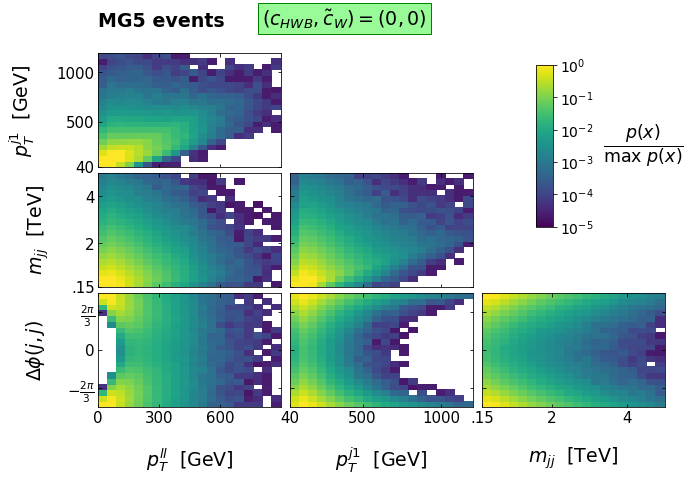

In [197]:

#  Plot MG5 events
datapoints_true, weights_true = data_tables[(0,0)].get_observables_and_weights()
plot_data_adv(datapoints_true, weights_true, label="MG5 events", savefig=f"figures/paper2D_model/EWK_events_SM_2D_true.pdf")


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


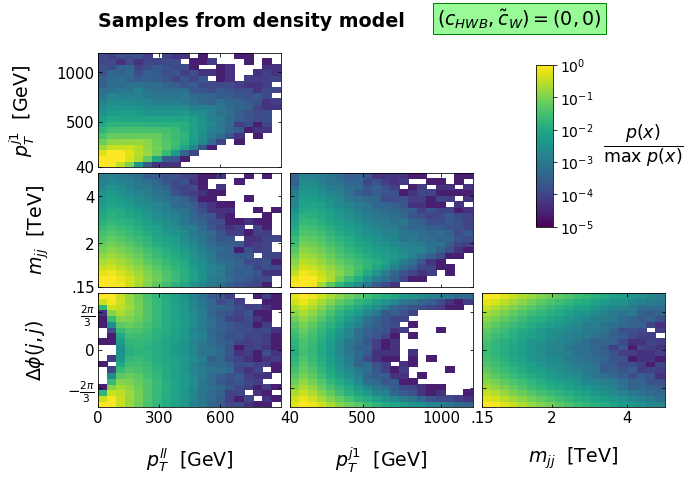

In [198]:

#  Plot generated events
plot_data_adv(fake_datapoints_SM_big, label="Samples from density model", savefig=f"figures/paper2D_model/EWK_events_SM_2D_fake.pdf")
